# Ultimate Challenge

## Part 1 - Exploratory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(1)

In [2]:
df = pd.read_json('logins.json')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


We can group the logins in 15-minute intervals and visualize.

In [5]:
df['num_logins']=1
df = df.set_index('login_time').resample('15min').sum()

In [6]:
df.describe()

,num_logins
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


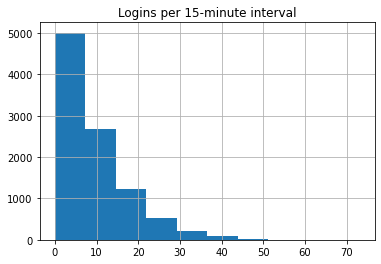

In [7]:
df.hist()
plt.title('Logins per 15-minute interval')
plt.show()

<AxesSubplot:>

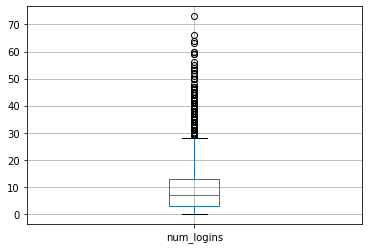

In [8]:
df.boxplot()

There are no missing values and the data distribution seems reasonable. Most of the login counts are between 0 and 30 per 15 minutes, with a significant right tail.

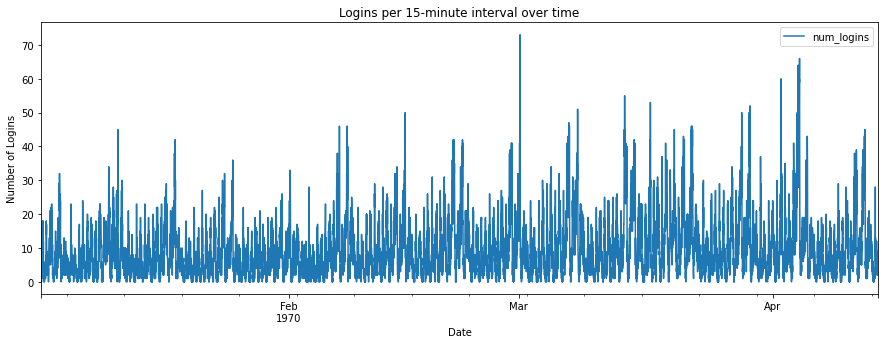

In [9]:
#plot the results
df.plot(xlabel='Date', ylabel='Number of Logins', figsize=(15,5), kind='line')
plt.title('Logins per 15-minute interval over time')
plt.show()

At a glance there appear to be weekly and daily patterns in addition to a slight longer term increase in variance over the four month time period. Seasonal decomposition can be used to extract the seasonal patterns from the long term trend. 

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# In one month there are 4 * 24 * 7 * 4 = 2688 fifteen-minute increments
decomp = seasonal_decompose(df.num_logins, period=2688)

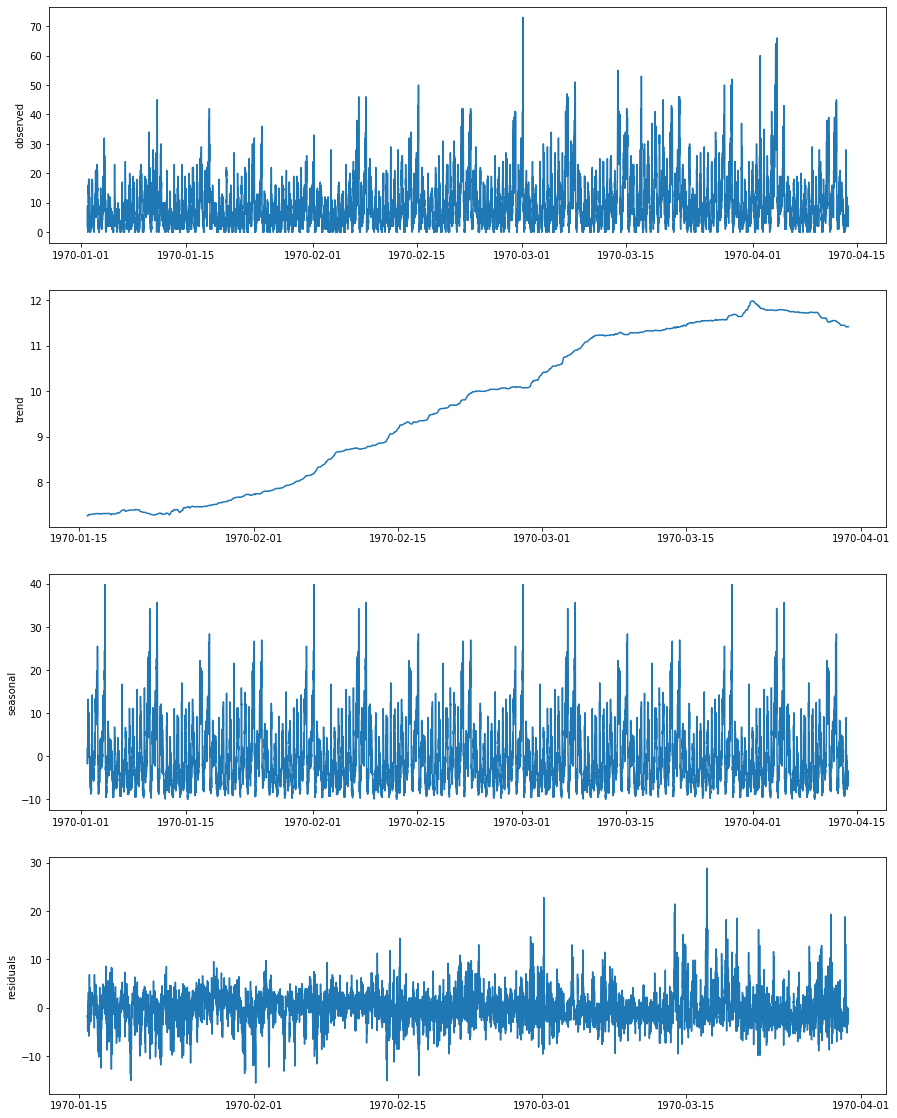

In [11]:
# Plot the original data, the trend, the seasonality, and the residuals 
fig, ax = plt.subplots(4, figsize=(15,20))

for i, attrib, name in zip([i for i in range(4)],
                        [decomp.observed, decomp.trend, decomp.seasonal, decomp.resid], 
                        ['observed', 'trend', 'seasonal', 'residuals']):
    ax[i].plot(attrib)
    ax[i].set_ylabel(name)
    
plt.show()

It looks as though we have separated the seasonality out and there is a gradual increase in logins from January to March. It is possible that there is further quarterly seasonality over the course of the year, but we do not have enough data to draw that conclusion. We can explore the monthly, weekly, and daily trends. 

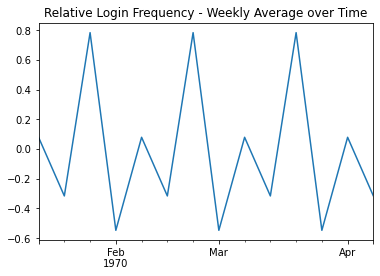

In [12]:
#resample weekly and plot, dropping first and last weeks due to edge effects
decomp.seasonal.resample('1W').mean()[1:-1].plot()
plt.title('Relative Login Frequency - Weekly Average over Time')
plt.xlabel(None)
plt.show()

It would appear that there is an alternating trend in weekly demand with an increase in login frequency every fourth week, typically the last week of the month. We can observe trends within the week by resampling daily and isolating a single week for ease of inspection.

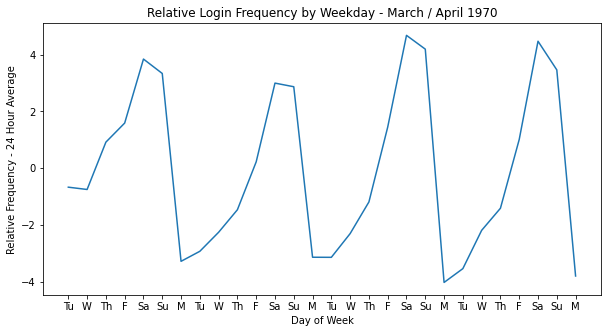

In [13]:
daily = decomp.seasonal.resample('1D').mean()
day_dict = {0:'M', 1:'Tu', 2:'W', 3:'Th', 4:'F', 5:'Sa', 6:'Su'}
#plot the last month of data
plt.figure(figsize=(10,5))
plt.plot(daily[-28:].index, daily[-28:].values)
plt.xticks(ticks=daily[-28:].index, 
           labels=daily[-28:].index.weekday.map(day_dict))
plt.xlabel('Day of Week')
plt.ylabel('Relative Frequency - 24 Hour Average')
plt.title('Relative Login Frequency by Weekday - March / April 1970')
plt.show()

There is a clear pattern with higher relative login frequency towards the end of the week and on the weekend, with a peak on Saturday and a drastic drop on Monday. We can look at daily patterns and how they change throughout the week as well.

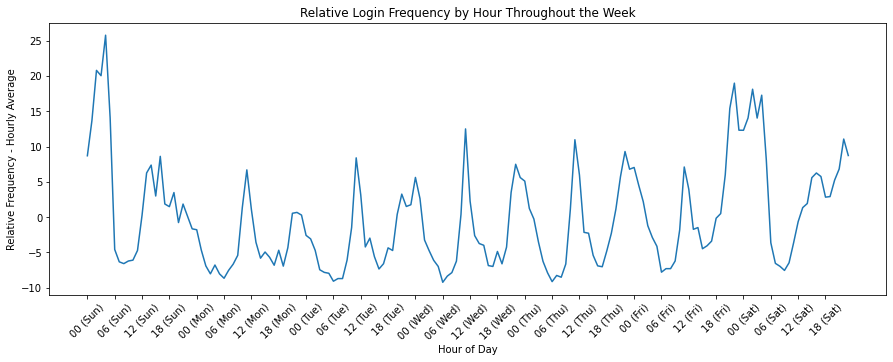

In [14]:
# resample hourly
hourly = decomp.seasonal.resample('1H').mean()

# changing i allows us to plot different weeks
i=1

# plot 
plt.figure(figsize=(15,5))
plt.plot(hourly[52 +7*24*i: 220 + 7*24*i].index, hourly[52 +7*24*i: 220 + 7*24*i].values)
plt.xticks(ticks=hourly[52 +7*24*i: 220 + 7*24*i:6].index, 
           labels=hourly[52 +7*24*i: 220 + 7*24*i:6].index.strftime('%H (%a)'),
           rotation=45)
plt.xlabel('Hour of Day')
plt.ylabel('Relative Frequency - Hourly Average')
plt.title('Relative Login Frequency by Hour Throughout the Week')
plt.show()

On weekdays there are sharp increases in logins around the lunch hour (12:00), and then a broader increase in logins during the evenings through to the next morning (from 6:00PM to 5:00AM with peak around 9PM to midnight). Weekends have broader ranges of increses in login times, with higher traffic more evenly distributed throughout the day and slightly later peak times in the evenings (~midnight to 2AM) with the highest login frequencies late Saturday night / early Sunday morning. Note that this a consistent pattern across weeks, which can be inspected by changing 'i' in the code above.

In summary, login demands are highest during the lunch hour and in the evenings, increase throughout the week, increase on the last week of the month, and have had an increasing baseline from January to April.

## Part 2 - Experiment and Metrics Design

1.The goal of the policy change is to encourage drivers to be available in both cities. Therefore the metric for success should reflect the desired outcome - namely, a number that reflects drivers serving passengers in both cities. For a single driver we can consider that they were available in both cities if they picked up at least one passenger  originating in each city in a single 24-hour period, with 24-hour periods measured from 6AM to 6AM, since this tends to be the time of lowest activity - call this an 'available-in-both' day of driving. For any period of time we could then look at the fraction of active days that a driver was 'available-in-both' and call this the 'fraction-days-available'. For a single driver we could then compute the difference in the 'fraction-days-available' from before and after the policy change, call this 'availability-change'. The lump metric could then be the average 'availability-change' for all drivers.

2a. In order to control for other confounding variables I would recommend randomizing a subset of drivers to receive a special pilot promotion of the toll reimbursement program to be the treatment group and the remaining drivers would serve as the control group. The subset of reimbursed drivers would need to be representative of the entire pool of drivers (e.g. in terms of location, how frequently they work, age, income, demographics). Trip data for both groups of drivers would be collected for a given amount of time (e.g. one month) before and after the promotion.

2b. Once the data is collected we can compute the 95% confidence interval for both the set of treatment and control availability-changes to determine if they are significantly different from zero. We can then compare the average 'availability-change' for both the treatment and control groups. We can perform a two-sided t-test to determine if there is a significant difference in the average availability-change of each group. We can compare the resulting t-statistic to the critical value for our desired confidence interval.

2c. If the p-value from the two-sided t-test is smaller than 0.05 then we can conclude with 95% confidence that driver behavior in the treatment group has changed from before the toll reimbursement policy was implemented. We cannot from the t-test alone determine the size of the effect but given the comparison with the control group we can be reasonably certain of whether or not the policy had an effect. This also would not be able to capture the effects of the policy on driver recruitment or retention, since the only valid participants would be drivers who are retained throughout the course of the study. More data exploration would be necessary to tease out these effects and others, such as seasonal effects. If the results show a significant change I would recommend that the team move forward with rolling out the policy, along with continued monitoring.

## Part 3 - Preditive Modeling

In [15]:
df = pd.read_json('ultimate_data_challenge.json', convert_dates=['signup_date', 'last_trip_date'])
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

There are some missing values for average rating of driver, average rating by driver, and phone type. While we could impute the missing data with averages, it is possible that it is meaningful that the information is missing. Therefore, we will fill null values with a signifier of -1 for numerical datatypes and "None" for strings. We will also convert booleans into integers.

In [17]:
df.avg_rating_of_driver = df.avg_rating_of_driver.fillna(value=-1)
df.avg_rating_by_driver = df.avg_rating_by_driver.fillna(value=-1)
df.phone = df.phone.fillna(value='None')
df.ultimate_black_user = df.ultimate_black_user.astype('int')

The brief says to consider a driver retained if they were active in the preceding 30 days. There is no information on when the data was pulled, but we can go by the latest logged date.

In [18]:
df.last_trip_date.describe(datetime_is_numeric=False)

<ipython-input-18-3701db79fe63>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.last_trip_date.describe(datetime_is_numeric=False)


count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [19]:
df['retained'] = (df.last_trip_date >= pd.to_datetime('2014-06-01')).astype('int')

In [20]:
df.retained.value_counts()

0    31196
1    18804
Name: retained, dtype: int64

In [21]:
pct = round(df.retained.value_counts()[1] / 50000 * 100)
print('{}% of drivers were retained.'.format(pct))

38% of drivers were retained.


In [22]:
from seaborn import heatmap

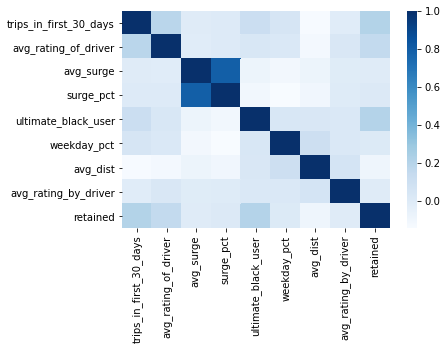

In [23]:
heatmap(df.corr(), cmap='Blues')
plt.show()

In terms of correlation coefficient, trips in the first 30 days and ultimate black user participation seem to be the strongest predictions of retention, followed by driver rating. However there doesn't seem to be strong dependence on any one feature overall. 

In [24]:
lost = df[df.retained == 0]
kept = df[df.retained == 1]

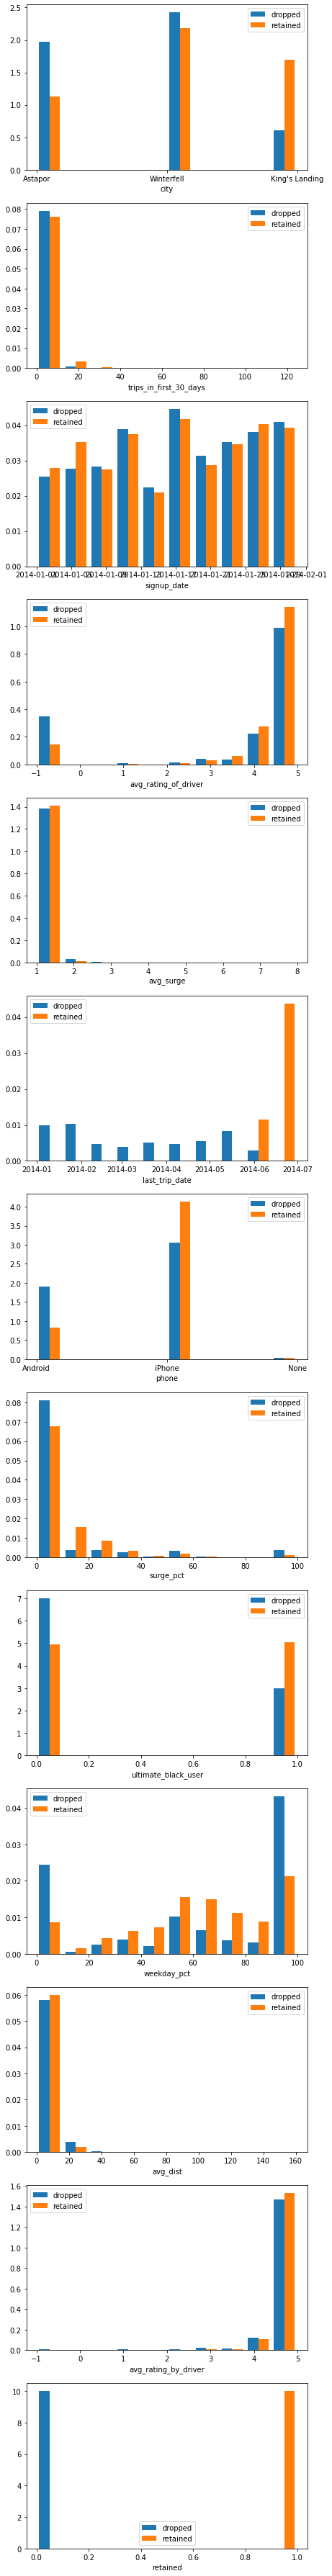

In [25]:
cols = df.columns
fig, axes = plt.subplots(len(cols), figsize=(7, 5*len(cols)))
for ax, col in zip(axes, cols): 
    ax.hist([lost[col], kept[col]], label=['dropped', 'retained'], density=True)
    ax.legend()
    ax.set_xlabel(col)
plt.show()

City, phone type, and ultimate black user seem to have the greatest difference in distributions between retained and dropped drivers, suggesting that they may have higher predictive power. Driver rating and weekday percentage may also have some influence, to a lesser extent.

In [26]:
df = pd.get_dummies(df).drop(columns=['signup_date', 'last_trip_date', 'city_Winterfell', 'phone_None'])
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,0,1,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1,0


## Model Exploration

We will start with decision tree methods, which do not require standardization of the input features.

In [27]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support, plot_precision_recall_curve, balanced_accuracy_score

import xgboost as xgb

In [28]:
X = df.drop(columns='retained').values
y = df.retained.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Random Forest Classifier

Since there is a slight imbalance among the classes, and since the goal is to predict user status as accurately as possible, balanced accuracy will be used as a scoring metric. 

In [29]:
params = {
 'max_depth': [None, 10, 50, 100],
 'criterion': ['gini', 'entropy'],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 4, 10],
 'n_estimators': [100, 200, 500, 1000]
}

rf = RandomForestClassifier(random_state=1)
rf_cv = RandomizedSearchCV(rf, params, cv=3, scoring='balanced_accuracy', verbose=5, random_state=1)
rf_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10, criterion=entropy 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10, criterion=entropy, score=0.759, total=   3.0s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10, criterion=entropy, score=0.756, total=   2.7s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10, criterion=entropy, score=0.758, total=   2.9s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, criterion=gini 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.5s remaining:    0.0s


[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, criterion=gini, score=0.749, total=  17.0s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, criterion=gini 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   25.5s remaining:    0.0s


[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, criterion=gini, score=0.752, total=  22.1s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, criterion=gini 
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, criterion=gini, score=0.757, total=  21.3s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=50, criterion=gini 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=50, criterion=gini, score=0.741, total=  22.8s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=50, criterion=gini 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=50, criterion=gini, score=0.736, total=  19.6s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=5

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 10.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 50, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 4, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   random_state=1, scoring='balanced_accuracy', verbose=5)

In [30]:
#examine cv results
pd.DataFrame(rf_cv.cv_results_).sort_values('rank_test_score').T

,4,7,3,0,6,5,8,1,9,2
mean_fit_time,6.41872,23.2184,12.7636,2.61418,31.3442,31.4356,13.1725,17.6882,34.5945,18.625
std_fit_time,0.310441,0.335147,1.10574,0.125762,2.84759,3.67914,1.2106,1.9625,0.899707,1.37355
mean_score_time,0.746189,2.22498,1.25577,0.220658,3.24046,2.27657,1.07189,2.45011,4.65466,1.97903
std_score_time,0.084277,0.0287239,0.161082,0.0162576,0.0440213,0.0312029,0.12618,0.356409,0.941255,0.170405
param_n_estimators,200,1000,500,100,1000,1000,500,500,1000,500
param_min_samples_split,4,10,2,4,4,4,4,10,4,2
param_min_samples_leaf,4,4,4,4,4,4,4,1,1,1
param_max_features,sqrt,sqrt,auto,auto,sqrt,sqrt,auto,auto,sqrt,sqrt
param_max_depth,100,10,10,10,50,10,10,50,50,50
param_criterion,gini,gini,gini,entropy,gini,entropy,entropy,gini,gini,gini


### XGBoost Classifier

In [31]:
params = {
    'max_depth': [None, 10, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'n_estimators': [10, 20, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1],
    'objective': ['binary:logistic']
}

xgb_clf = xgb.XGBClassifier(random_state=1)
xgb_cv = RandomizedSearchCV(xgb_clf, params, cv=3, scoring='balanced_accuracy', verbose=5, random_state=1)

xgb_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] objective=binary:logistic, n_estimators=20, min_child_weight=1.0, max_depth=50, learning_rate=0.001, gamma=0, colsample_bytree=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  objective=binary:logistic, n_estimators=20, min_child_weight=1.0, max_depth=50, learning_rate=0.001, gamma=0, colsample_bytree=1, score=0.717, total=   1.9s
[CV] objective=binary:logistic, n_estimators=20, min_child_weight=1.0, max_depth=50, learning_rate=0.001, gamma=0, colsample_bytree=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  objective=binary:logistic, n_estimators=20, min_child_weight=1.0, max_depth=50, learning_rate=0.001, gamma=0, colsample_bytree=1, score=0.715, total=   1.7s
[CV] objective=binary:logistic, n_estimators=20, min_child_weight=1.0, max_depth=50, learning_rate=0.001, gamma=0, colsample_bytree=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV]  objective=binary:logistic, n_estimators=20, min_child_weight=1.0, max_depth=50, learning_rate=0.001, gamma=0, colsample_bytree=1, score=0.714, total=   1.8s
[CV] objective=binary:logistic, n_estimators=100, min_child_weight=3.0, max_depth=50, learning_rate=0.2, gamma=0, colsample_bytree=0.5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s


[CV]  objective=binary:logistic, n_estimators=100, min_child_weight=3.0, max_depth=50, learning_rate=0.2, gamma=0, colsample_bytree=0.5, score=0.751, total=   6.8s
[CV] objective=binary:logistic, n_estimators=100, min_child_weight=3.0, max_depth=50, learning_rate=0.2, gamma=0, colsample_bytree=0.5 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.1s remaining:    0.0s


[CV]  objective=binary:logistic, n_estimators=100, min_child_weight=3.0, max_depth=50, learning_rate=0.2, gamma=0, colsample_bytree=0.5, score=0.745, total=   7.2s
[CV] objective=binary:logistic, n_estimators=100, min_child_weight=3.0, max_depth=50, learning_rate=0.2, gamma=0, colsample_bytree=0.5 
[CV]  objective=binary:logistic, n_estimators=100, min_child_weight=3.0, max_depth=50, learning_rate=0.2, gamma=0, colsample_bytree=0.5, score=0.757, total=   6.8s
[CV] objective=binary:logistic, n_estimators=10, min_child_weight=5.0, max_depth=None, learning_rate=0.1, gamma=0, colsample_bytree=0.9 
[CV]  objective=binary:logistic, n_estimators=10, min_child_weight=5.0, max_depth=None, learning_rate=0.1, gamma=0, colsample_bytree=0.9, score=0.754, total=   0.3s
[CV] objective=binary:logistic, n_estimators=10, min_child_weight=5.0, max_depth=None, learning_rate=0.1, gamma=0, colsample_bytree=0.9 
[CV]  objective=binary:logistic, n_estimators=10, min_child_weight=5.0, max_depth=None, learning_

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   45.2s finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [32]:
#examine cv results
pd.DataFrame(xgb_cv.cv_results_).sort_values('rank_test_score').T

,5,4,7,2,1,6,8,9,3,0
mean_fit_time,2.04149,0.346248,0.231661,0.244592,6.72875,2.07208,0.282726,0.454309,0.266941,1.72807
std_fit_time,0.158163,0.00587055,0.00435877,0.000917679,0.147633,0.0126811,0.00999001,0.0274946,0.00517324,0.0837297
mean_score_time,0.0726719,0.0427882,0.0391695,0.0404636,0.184867,0.064455,0.0430041,0.0419196,0.0377874,0.0515112
std_score_time,0.0100417,0.00309419,0.00218384,0.00225661,0.0264367,0.000849492,0.00229685,0.00106789,0.0016488,0.0045933
param_objective,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic
param_n_estimators,100,20,10,10,100,100,10,20,10,20
param_min_child_weight,3,3,0.5,5,3,5,0.5,0.5,3,1
param_max_depth,None,None,None,None,50,None,10,None,None,50
param_learning_rate,0.2,0.3,0.3,0.1,0.2,0.001,0.1,0.01,0.01,0.001
param_gamma,0,0.5,1,0,0,0.25,0,0.25,0,0


The XGBoost classifier performs slightly better than the RandomForest classifier with a top mean balanced accuracy of 77%.

## K-Means Classifier

In [33]:
#first scale data
from sklearn.preprocessing import StandardScaler

In [34]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

In [35]:
from sklearn.neighbors import KNeighborsClassifier

In [36]:
#try several values for n_neighbors
scores_dict = {}
for i in list(range(2,9,2)) + list(range(10,100,10)):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, X_tr_scaled, y_train, scoring='balanced_accuracy', cv=3)
    temp = {}
    temp['mean'] = np.mean(scores)
    temp['std'] = np.std(scores)
    scores_dict[i] = temp


<AxesSubplot:xlabel='index', ylabel='mean'>

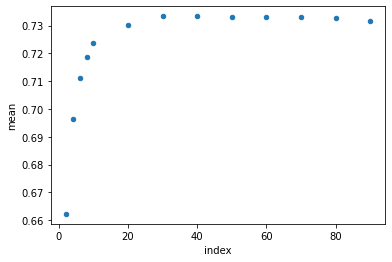

In [37]:
pd.DataFrame(scores_dict).T.reset_index().plot(x='index', y='mean', kind='scatter')

The optimal choice for neighbors seems to be 30, but this still achieves balanced accuracy of only about 73%.

### Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
X_trs, X_vals, y_tr, y_val = train_test_split(X_tr_scaled, y_train, test_size=0.2)

In [40]:
lr = LogisticRegression()
lr.fit(X_trs, y_tr)
y_tr_preds = lr.predict(X_trs)
y_val_preds = lr.predict(X_vals)

In [41]:
balanced_accuracy_score(y_tr, y_tr_preds)

0.6780777015411315

In [42]:
balanced_accuracy_score(y_val, y_val_preds)

0.6801774377666072

### Model Selection and Evaluation

The XGBoost model shows the best overall performance with a cross-validated balanced accuracy of 77%. We can now train on the entire test set and take a closer look at the model performance with the confusion matrix.

In [43]:
xgb_clf = xgb_cv.best_estimator_

xgb_clf.fit(X_train, y_train)

y_preds = xgb_clf.predict(X_test)

In [44]:
balanced_accuracy_score(y_test, y_preds)

0.7624233048549749

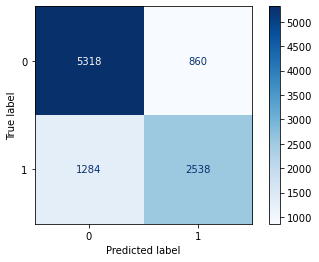

In [45]:
plot_confusion_matrix(xgb_clf, X_test, y_test, cmap='Blues')

In [46]:
accuracy = (5362 + 2569) / (5362 + 2569 + 1253 + 816)
print('The overall test accuracy is {}'.format(accuracy))

The overall test accuracy is 0.7931


In [47]:
pd.DataFrame(precision_recall_fscore_support(y_test, y_preds), 
             index=['Precision', 'Recall', 'Fscore', 'Support'])

,0,1
Precision,0.805513,0.746910
Recall,0.860796,0.664050
Fscore,0.832238,0.703047
Support,6178.000000,3822.000000


In [48]:
from sklearn.metrics import plot_roc_curve

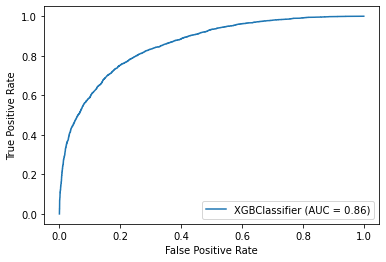

In [49]:
plot_roc_curve(xgb_clf, X_test, y_test)

In [50]:
#use SHAP package to explore feature importance
import shap

explainer = shap.Explainer(xgb_clf.predict, X_test)
shap_values = explainer(X_test)

Permutation explainer: 10001it [12:41, 13.04it/s]                          


In [51]:
feature_names = df.drop(columns='retained').columns
shap_values.feature_names = feature_names

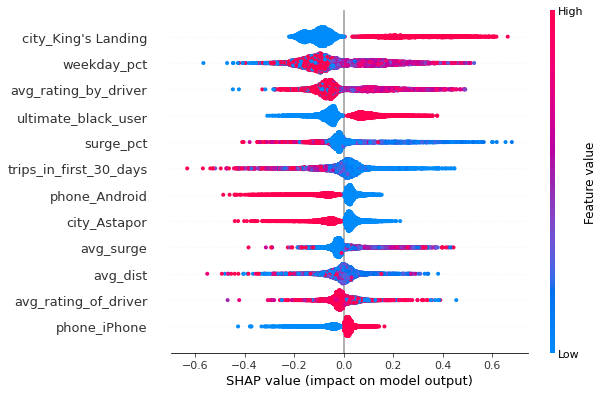

In [52]:
shap.plots.beeswarm(shap_values)

The final XGB classifier has a balanced accuracy of 76% and an overall accuracy of 79%, as compared to the baseline accuracy which would be 62%. The model recall for the positive class is one area of concern as it is only 66%. However, this model was optimized for overall accuracy based on Ultimate's stated goal to predict user status. I would recommend reoptimizing the model for recall if Ultimate instead wanted to identify drivers in danger of being dropped so that an intervention could be implemented (e.g. special deals). 

The SHAP plot suggests some areas that Ultimate could focus on in improving driver retention. Drivers in King's Landing are more likely to be predicted retained and drivers in Astapor are more likely to be predicted dropped. I would recommend investigating why this is. Drivers who take an Ultimate Black in their first 30 days are more likely to be predicted retained. Ultimate may therefore wish to incentivize more drivers to take an Ultimate Black. Also, iPhone users are more likely to be predicted retained than Android users. This could be due to confounding factors, or it could be due to design differences in the Ultimate app for iPhone vs Android. I would recommend taking a closer look at app data or designing some A/B tests to investigate this. Finally, drivers who mostly drive on weekends are less likely to be retained. This is logical as their driving patterns suggest they are driving part time, perhaps in addition to another job that takes up their weekend time. 